### Agenda

* Data Introduction
    - About the Game
    - About the Data
    - Feature Engineering/Selection
    - The Multicollinearity problem

*  t-SNE
    - observing bins vs avg win probability of features used for modeling
    
* Modeling GBC & MLP
    - MLP 3 Hidden Layers model specifications
    - Hyperpermeter Tuning (MLP)
    - MLP 7 Hidden Layers model specifications


* Model Evaluation
    - Defining Scores Used
    - Comparing Scores

* Practical Uses (It's just a game LOL)

* Final notes future work needed to make practical uses feasible & future work ideas

### Data Introduction

## About the game
League of Legends (LoL) is a multiplayer online battle arena video game developed and published by Riot Games. In League of Legends, players assume the role of a "champion" with unique abilities and battle against a team of other players- or computer-controlled champions. The goal is usually to destroy the opposing team's "Nexus", a structure that lies at the heart of a base protected by defensive structures, although other distinct game modes exist as well with varying objectives, rules, and maps. Each League of Legends match is discrete, with all champions starting off relatively weak but increasing in strength by accumulating items and experience over the course of the game.

https://www.youtube.com/watch?v=mwERJ6qJPuc

About the Data

So what we have is a ten-minute snapshot of scalars reflecting an aspect of team performance and whether that team won or not. 

Target

Our "bluewins" variable is the target and it is a binary feature. The overall goal of this analysis is to extract informative indicators that may lead the blue team to win or lose a match.

In [20]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.manifold import TSNE
import scipy
import time
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
import datetime, os, io
from google.colab import files
%matplotlib inline

### The Data 

Distribution Chart
We have mixed data types here discreet and continuous. There are noticeable skew and kurtosis aspects of these distributions that vary from what I'd expect to see with a normal distribution, but overall it looks pretty good to me. Not too much data cleaning was needed which was nice, but this dataset presented its own problems which I will glance over later. 

### Feature Engineering

For feature engineering, I created 15 different metrics and I also experimented with team acquisition ratios of different buffs based on what is obtainable within the first ten minutes of a game.

Saving high_diamond_ranked_10min.csv to high_diamond_ranked_10min.csv


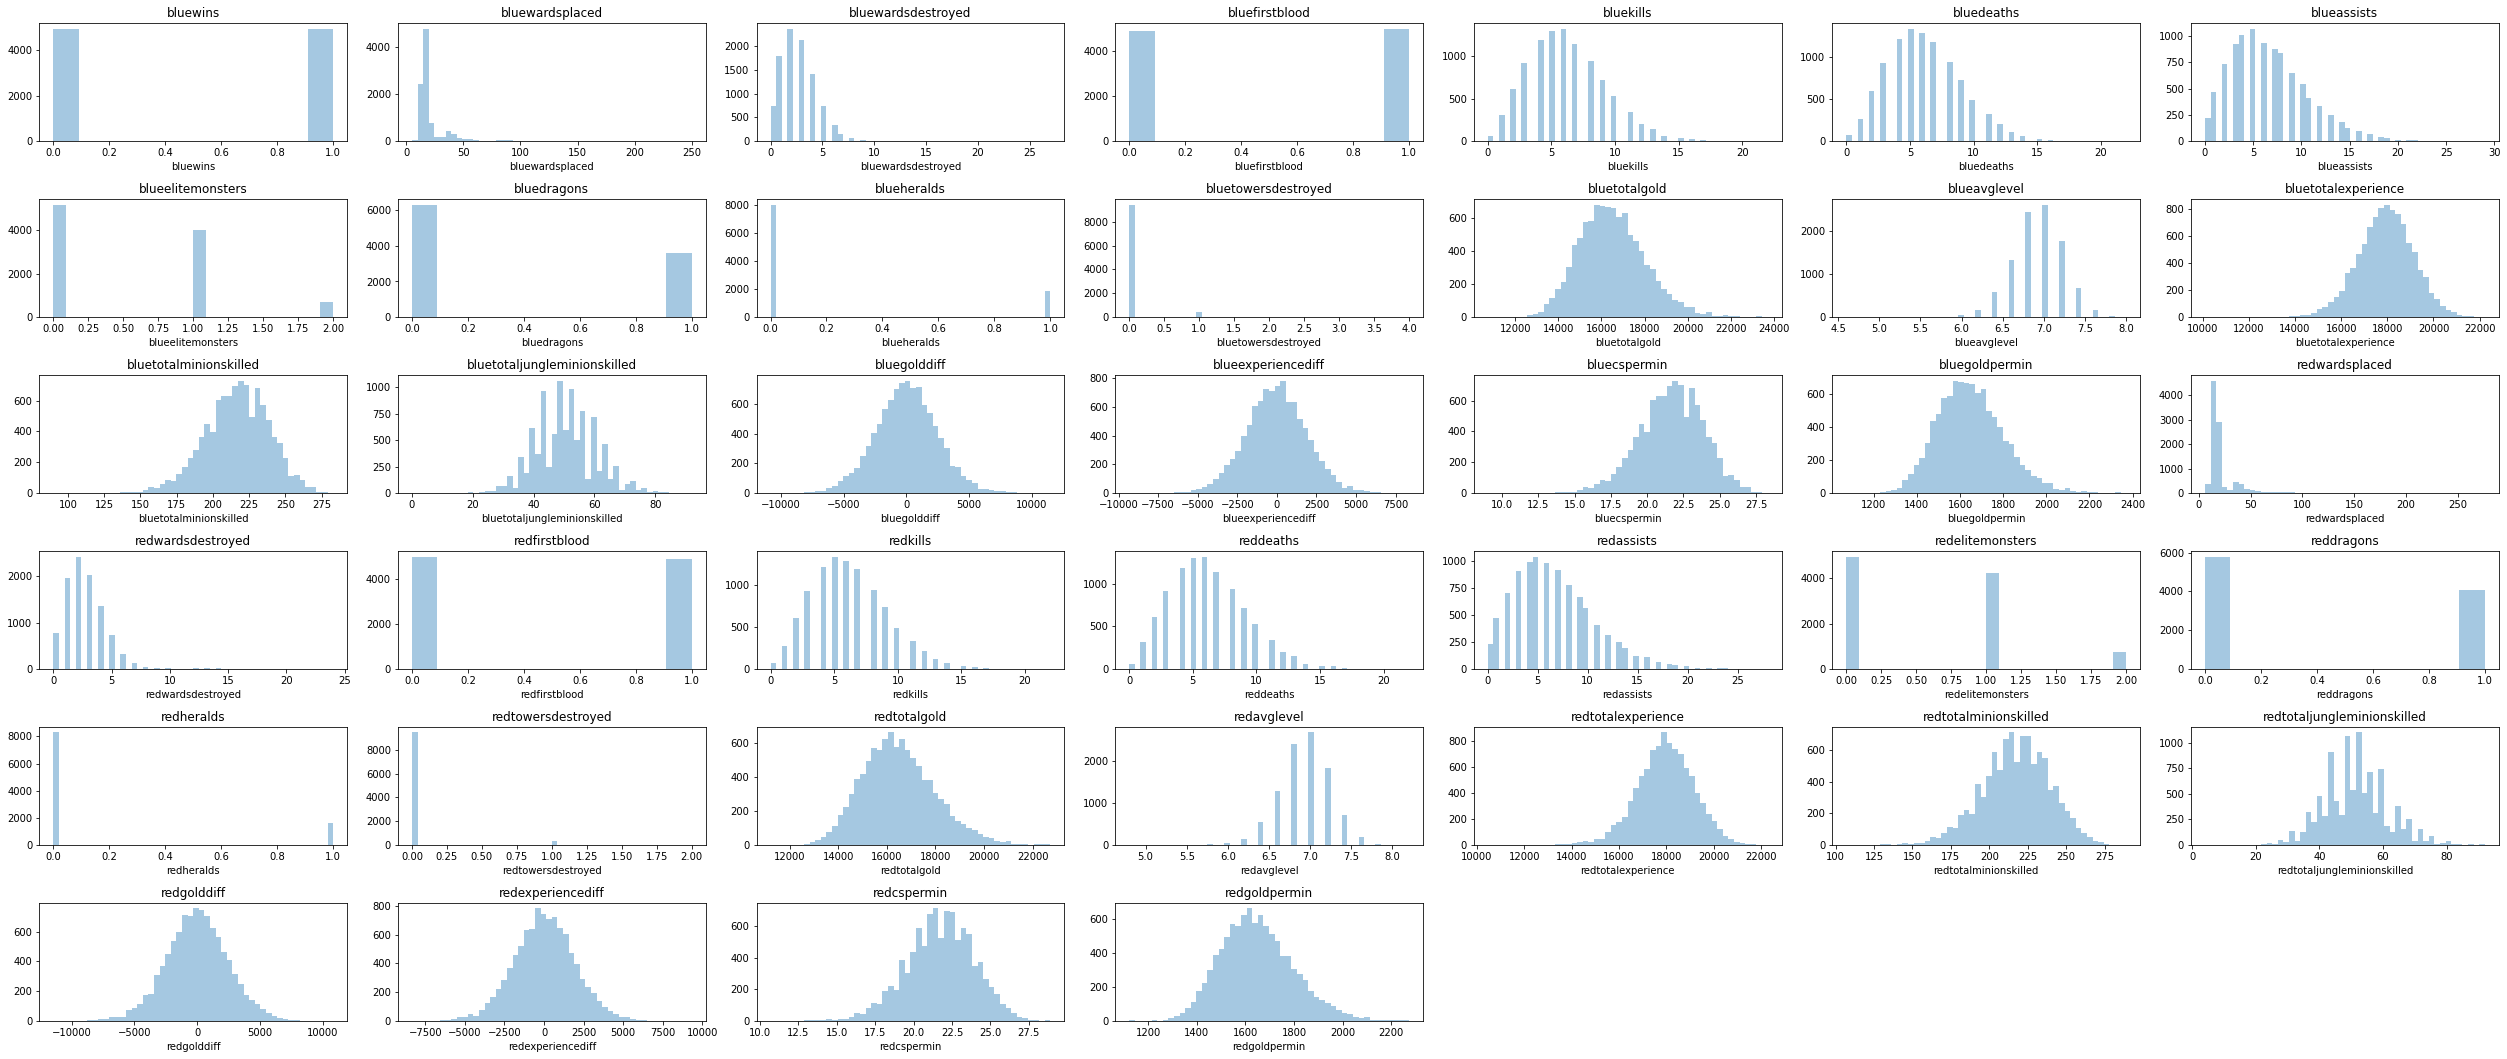

In [2]:
# Uploading data
uploaded = files.upload()
df_og = pd.read_csv(io.BytesIO(uploaded['high_diamond_ranked_10min.csv']))
df_og.columns = map(lambda x:x.lower(), df_og.columns)
df_og['gameid'] = df_og['gameid'].astype(str)
numeric_columns = df_og.select_dtypes(['int64', 'float64']).columns
FILL_LIST = []
for cols in df_og[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)
plt.figure(figsize=(35, 95))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    try:
        plt.subplot(len(FILL_LIST), 7, i+1)
        sns.distplot(df_og[col], kde=False)
        plt.title(col)
    except TypeError:
        pass
plt.tight_layout()

In [3]:
# Just incase
df1 = df_og.copy()

# Feature Engineering comparative team performance variables
df1['bcspermin_diff'] = df1['bluecspermin'] - df1['redcspermin']
df1['btotexp_diff'] = df1['bluetotalexperience'] - df1['redtotalexperience']
df1['bavglvl_diff'] = df1['blueavglevel'] - df1['redavglevel']
df1['bwardsplaced_diff'] = df1['bluewardsplaced'] - df1['redwardsplaced']
df1['bwardsdestroyed_diff'] = df1['bluewardsdestroyed'] - df1['redwardsdestroyed']
df1['btowerdeaths_diff'] = df1['bluetowersdestroyed'] - df1['redtowersdestroyed']
df1['bkills_diff'] = df1['bluekills'] - df1['redkills']
df1['bdeaths_diff'] = df1['bluedeaths'] - df1['reddeaths']
df1['bgold_per_min_diff'] = df1['bluegoldpermin'] - df1['redgoldpermin']
df1['belite_diff'] = df1['blueelitemonsters'] - df1['redelitemonsters']
df1['bdrag_diff'] = df1['bluedragons'] - df1['reddragons']
df1['bheralds_diff'] = df1['blueheralds'] - df1['redheralds']
df1['blaneminions_diff'] = df1['bluetotalminionskilled'] - df1['redtotalminionskilled']
df1['bjgmionions_diff'] = df1['bluetotaljungleminionskilled'] - df1['redtotaljungleminionskilled']
df1['bteamtotminionsdiff'] = (df1['blueelitemonsters'] + df1['bluedragons'] + df1['blueheralds'] + df1['bluetotalminionskilled'] + df1['bluetotaljungleminionskilled']) - (df1['redelitemonsters'] + df1['reddragons'] + df1['redheralds'] + df1['redtotalminionskilled'] + df1['redtotaljungleminionskilled'])

df_ana = df1.loc[:, ['gameid', 'bluewins', 'bluegolddiff', 'blueexperiencediff', 'bkills_diff',
                     'bavglvl_diff', 'bluegoldpermin', 'bluetotalexperience',
                     'blueavglevel', 'bteamtotminionsdiff', 'bluekills',
                     'bcspermin_diff', 'blaneminions_diff', 'bluetotalgold']]

### Features Selected 

I made use of skLearn's SelectKBest and Anova test functions to help me pinpoint the best variables to proceed with.

'bluewins' - binary target

'bluegolddiff' - the difference in accumulated gold

'blueexperiencediff' - the difference in accumulated experience

'bluegoldpermin' - gold accumulated per minute

'bluetotalexperience' - total experienced gained

'bteamtotminionsdiff' - blue team total minions including (elite, rift, and jungle minions) killed compared to red team killed

'blaneminions_diff' - blue team total lane minion difference

'bluetotalgold' - blue total gold acquired


Saving data_chi3_anova9.csv to data_chi3_anova9.csv


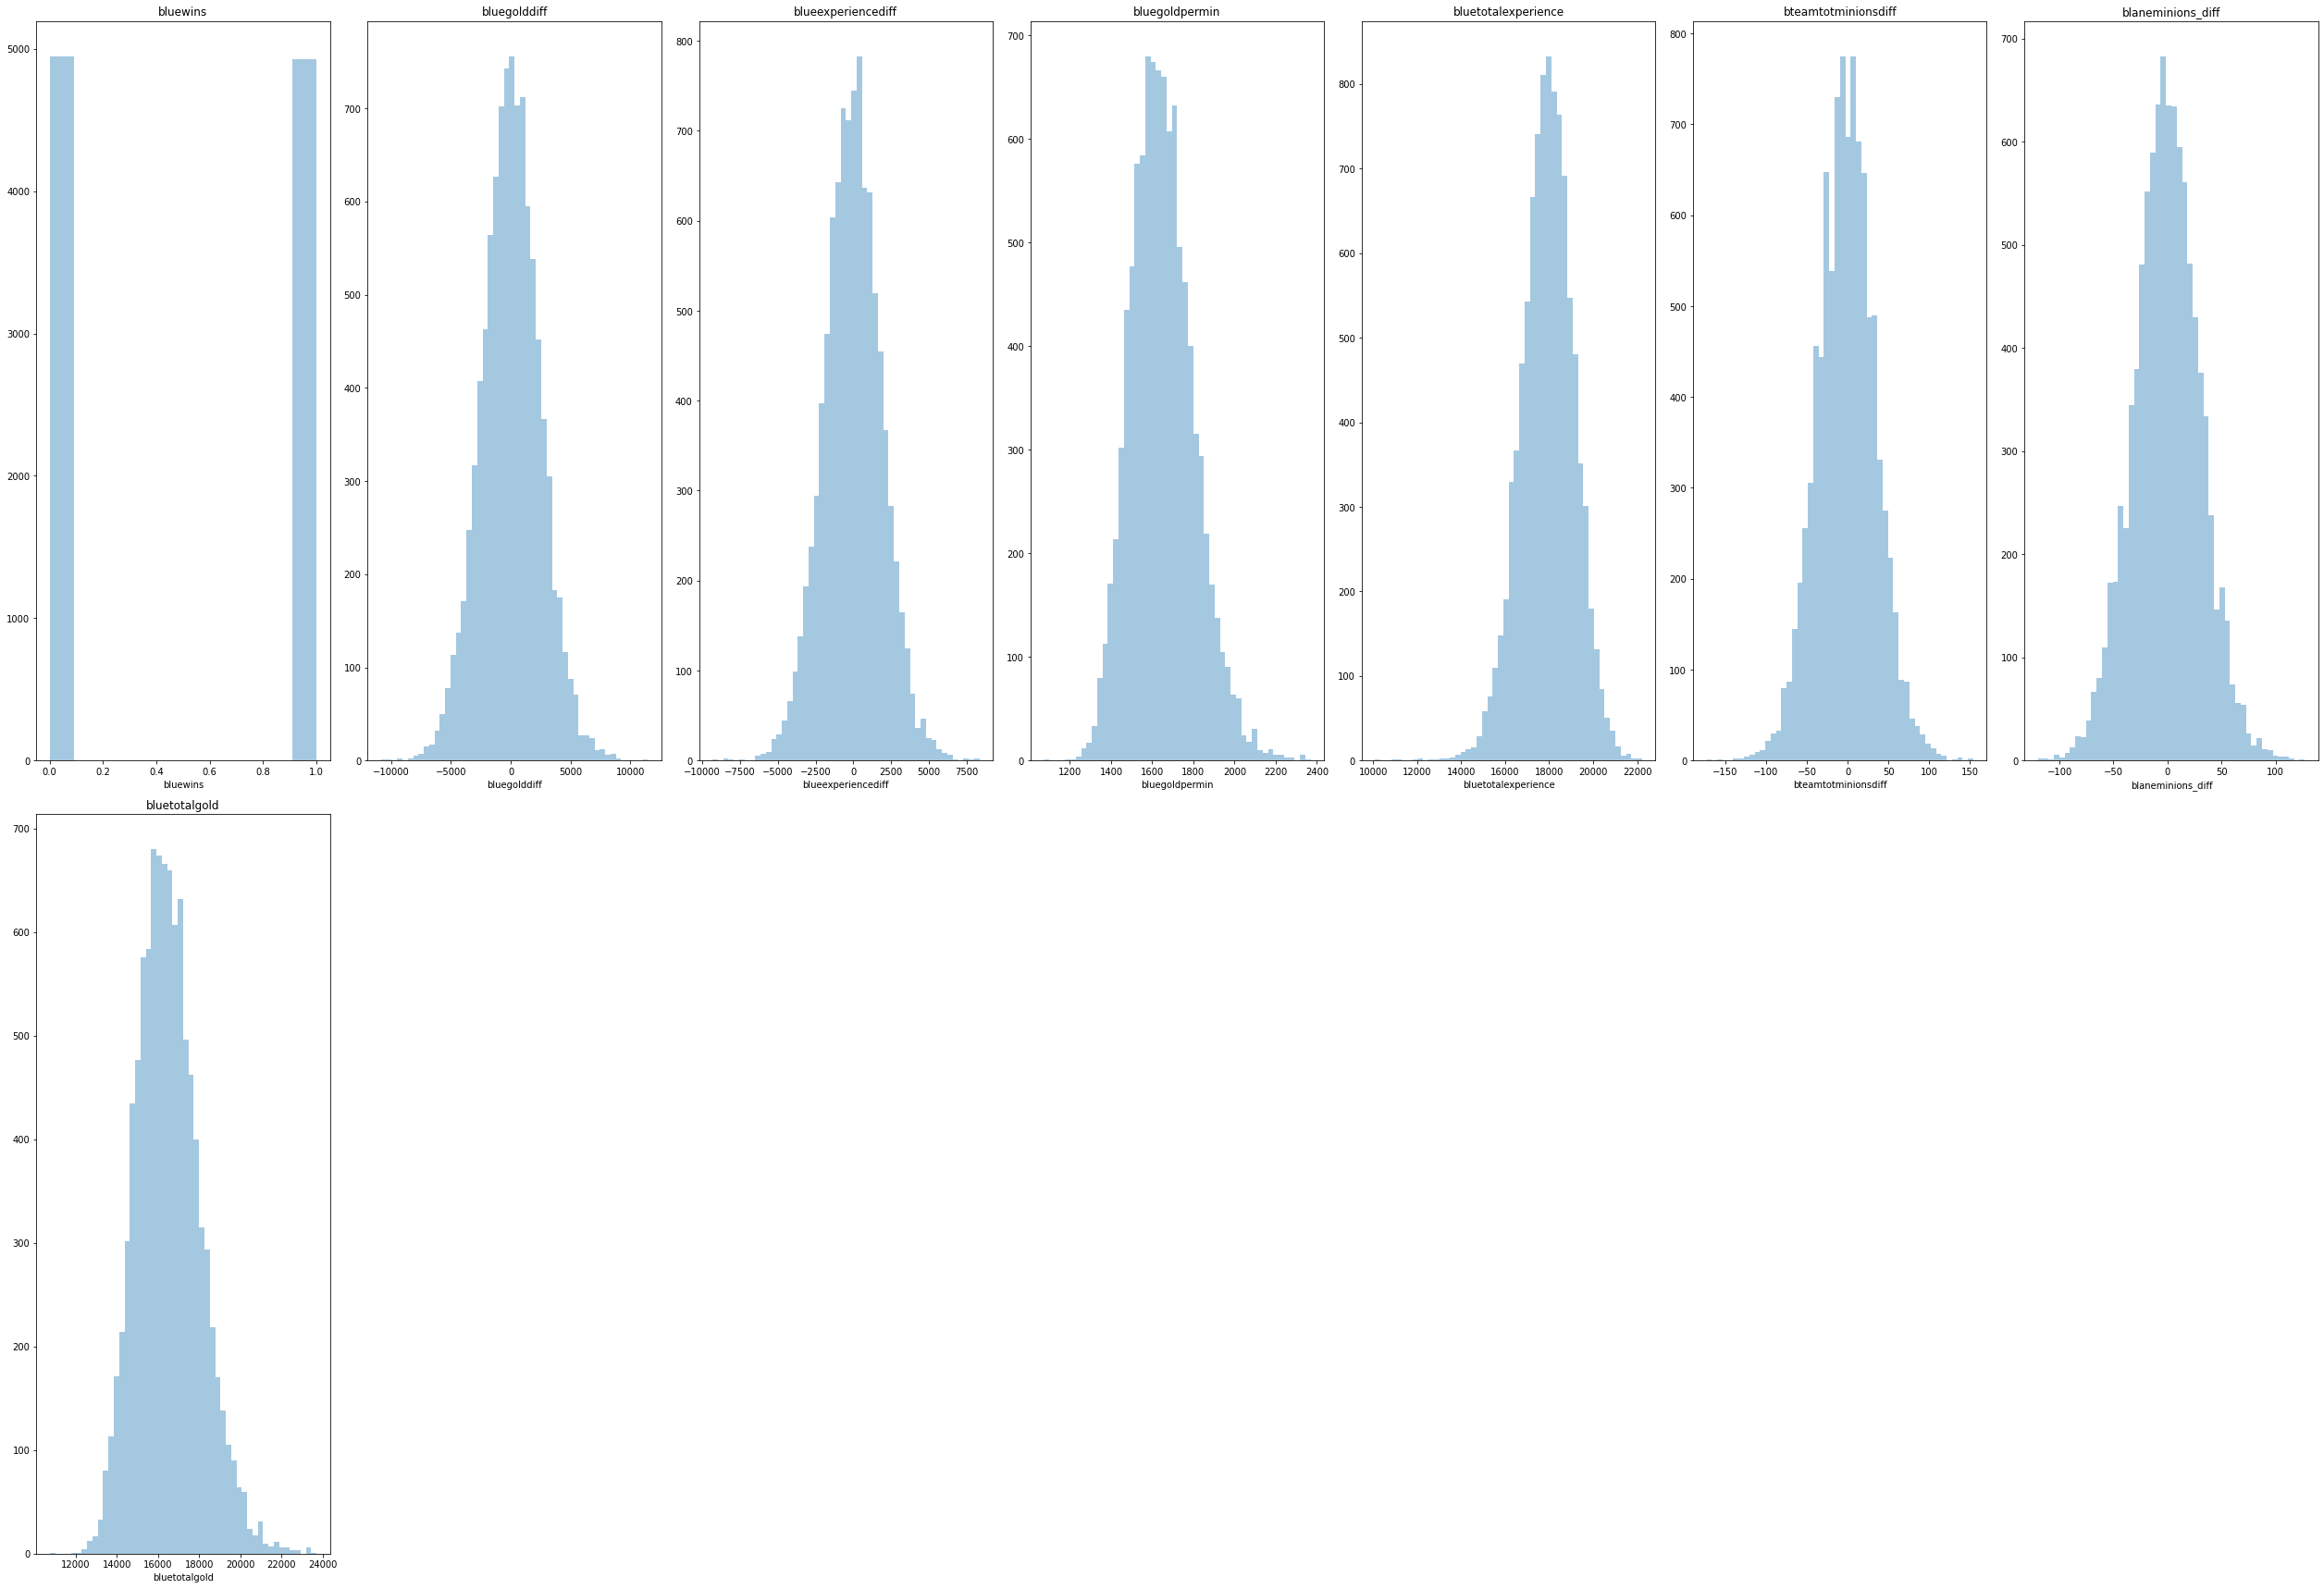

In [4]:
# Uploading data
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['data_chi3_anova9.csv']))
df = df.drop(['Unnamed: 0'], axis = 1)
df.columns = map(lambda x:x.lower(), df.columns)
df['gameid'] = df['gameid'].astype(str)
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
FILL_LIST = []
for cols in df[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)
plt.figure(figsize=(35, 95))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    try:
        plt.subplot(len(FILL_LIST), 7, i+1)
        sns.distplot(df[col], kde=False)
        plt.title(col)
    except TypeError:
        pass
plt.tight_layout()

### Novel Data Problem

Every dataset has it's quirks and this one is no different. Interestingly enough there is a persistence of multicollinearity with the features that correlate with the target considering correlation at a minimum of 0.4. It is for this reason that Principle Component Analysis piped into K-Means could not produce definitive separability between games where the blue team won or lost the match.


bluewins               1.000000
bluegolddiff           0.511119
blueexperiencediff     0.489558
bkills_diff            0.479379
bavglvl_diff           0.452927
bluegoldpermin         0.417213
bluetotalgold          0.417213
bluetotalexperience    0.396141
blueavglevel           0.357820
bteamtotminionsdiff    0.352974
bluekills              0.337358
bcspermin_diff         0.309126
blaneminions_diff      0.309126
Name: bluewins, dtype: float64

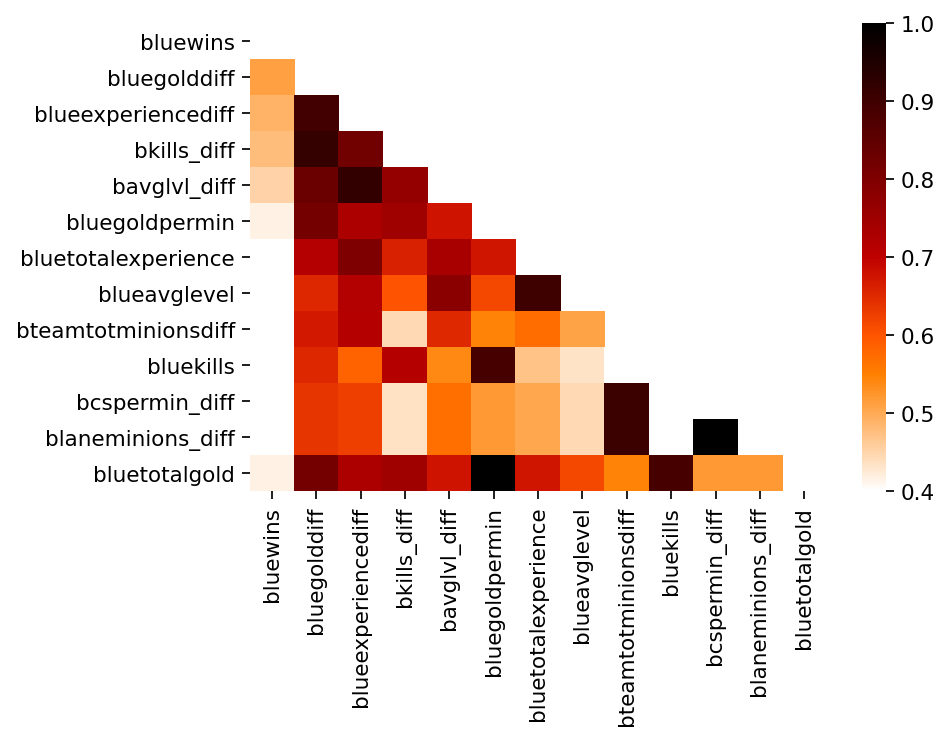

In [5]:
mask = np.zeros_like(df_ana.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(dpi=155)
sns.heatmap(abs(df_ana.corr()), mask=mask, vmin=0.4, cmap='gist_heat_r')
df_ana.corr()['bluewins'].sort_values(ascending=False)

The below cells goes from X & y to implementing and plotting t-SNE.

In [6]:
X = df.iloc[:, 2:]
y = df['bluewins'].values.ravel()
scaler = preprocessing.StandardScaler()
X_stand = scaler.fit_transform(X)
X_stand_df = pd.DataFrame(X_stand, columns=X.columns)
feat_cols = [ X_stand_df.columns[i] for i in range(X_stand_df.shape[1]) ]
data2 = pd.DataFrame(X_stand_df,columns=feat_cols)
data2['y'] = y
data2['label'] = data2['y'].apply(lambda i: str(i))

# For reproducability of the results
np.random.seed(57)

# random observation selection
rndperm = np.random.permutation(data2.shape[0])

# Number of observations to use during cluster selection
N = 9000

# dataframe obj holding randomly selected data
data_subset = data2.loc[rndperm[:N],:].copy()

# data values obj from dataframe
df_subset = data_subset[feat_cols].values

time_start = time.time()

tsne = TSNE(n_components=2,
            verbose=1,
            n_iter=1000,
            perplexity=30,
            learning_rate=300,
            early_exaggeration=12)

tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elasped: {} seconds'.format(time.time() - time_start))

data_subset['tsne-2d-one'] = tsne_results[:,0]
data_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.015s...
[t-SNE] Computed neighbors for 9000 samples in 0.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.379335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.960922
[t-SNE] KL divergence after 1000 iterations: 1.683643
t-SNE done! Time elasped: 75.67737984657288 seconds


### t-SNE

This is when I made use of the t stochastic neighbor embedded model created by Laurens van der Maaten and Geoffrey Hinton, to explore/visualize dimensional separability between games where the blue team won or lost. This is the final product of that exploration. t-SNE makes use of the student t-test to compare variables in a high and low dimensional space using distance to assume similarity. 

It's easiest to think of every point on this plot as a game with the most similar results of that ten-minute snapshot clustered together and the point's color represents that game result. Looking at this two-dimensional plot and considering the four quadrants of it we can observe that a loss likely to occur if team performance in the first ten minutes of the game is more similar to the games in quadrants I & III vs II & IV, where it appears you are more likely to win as the blue team. There appears to be very little intermingling here of the red and blue points, which is good to see and fun to work through. Seeing is believing and now that we can observe some sort of boundary, we can take a peek at how each of the selected variables impacts where are likely to at the end of a game. 

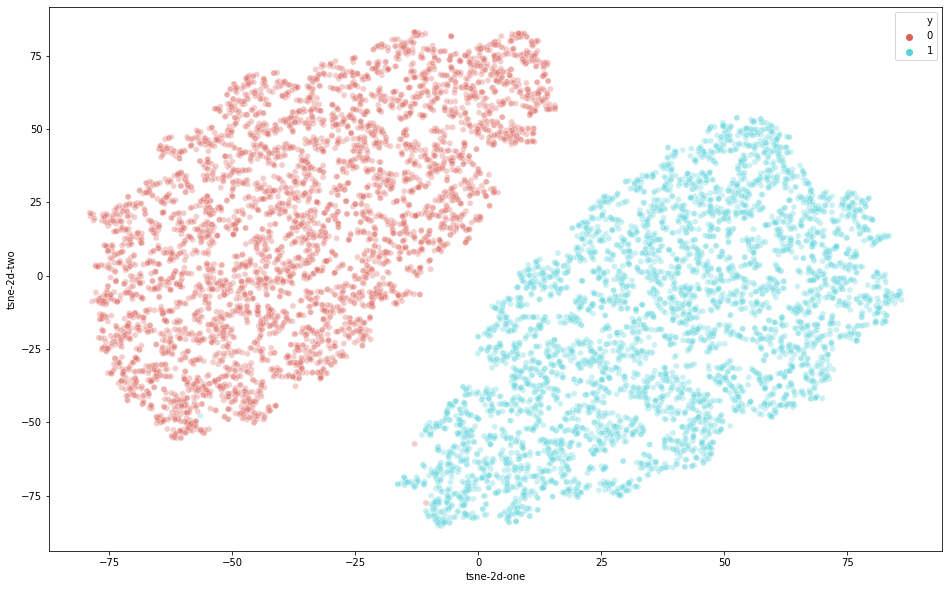

In [7]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=data_subset,
    legend="full",
    alpha=0.3)

In [8]:
# Binning features in new Dataframes for Visualizing
df_bins = df.copy()
df_bins['bluegolddiff_bins'] = pd.qcut(df_bins['bluegolddiff'], q=10)
pw_gd = df_bins.groupby('bluegolddiff_bins')['bluewins'].mean()
pw_gd = pw_gd.reset_index()
pw_gd.columns = ['bluegolddiff_bins', 'wp_bluegolddiff']
pw_gd['Delta'] = pw_gd['wp_bluegolddiff'].shift(-1) - pw_gd['wp_bluegolddiff']

df_bins['blueexperiencediff_bins'] = pd.qcut(df_bins['blueexperiencediff'], q=10)
pw_be = df_bins.groupby('blueexperiencediff_bins')['bluewins'].mean()
pw_be = pw_be.reset_index()
pw_be.columns = ['blueexperiencediff_bins', 'wp_blueexperiencediff']
pw_be['Delta'] = pw_be['wp_blueexperiencediff'].shift(-1) - pw_be['wp_blueexperiencediff']

df_bins['bluegoldpermin_bins'] = pd.qcut(df_bins['bluegoldpermin'], q=10)
pw_gm = df_bins.groupby('bluegoldpermin_bins')['bluewins'].mean()
pw_gm = pw_gm.reset_index()
pw_gm.columns = ['bluegoldpermin_bins', 'wp_bluegoldpermin']
pw_gm['Delta'] = pw_gm['wp_bluegoldpermin'].shift(-1) - pw_gm['wp_bluegoldpermin']

df_bins['bluetotalexperience_bins'] = pd.qcut(df_bins['bluetotalexperience'], q=10)
pw_te = df_bins.groupby('bluetotalexperience_bins')['bluewins'].mean()
pw_te = pw_te.reset_index()
pw_te.columns = ['bluetotalexperience_bins', 'wp_bluetotalexperience']
pw_te['Delta'] = pw_te['wp_bluetotalexperience'].shift(-1) - pw_te['wp_bluetotalexperience']

df_bins['bteamtotminionsdiff_bins'] = pd.qcut(df_bins['bteamtotminionsdiff'], q=10)
pw_tm = df_bins.groupby('bteamtotminionsdiff_bins')['bluewins'].mean()
pw_tm = pw_tm.reset_index()
pw_tm.columns = ['bteamtotminionsdiff_bins', 'wp_bteamtotminionsdiff']
pw_tm['Delta'] = pw_tm['wp_bteamtotminionsdiff'].shift(-1) - pw_tm['wp_bteamtotminionsdiff']

df_bins['blaneminions_diff_bins'] = pd.qcut(df_bins['blaneminions_diff'], q=10)
pw_lm = df_bins.groupby('blaneminions_diff_bins')['bluewins'].mean()
pw_lm = pw_lm.reset_index()
pw_lm.columns = ['blaneminions_diff_bins', 'wp_blaneminions_diff']
pw_lm['Delta'] = pw_lm['wp_blaneminions_diff'].shift(-1) - pw_lm['wp_blaneminions_diff']

df_bins['bluetotalgold_bins'] = pd.qcut(df_bins['bluetotalgold'], q=10)
pw_tg = df_bins.groupby('bluetotalgold_bins')['bluewins'].mean()
pw_tg = pw_tg.reset_index()
pw_tg.columns = ['bluetotalgold_bins', 'wp_bluetotalgold']
pw_tg['Delta'] = pw_tg['wp_bluetotalgold'].shift(-1) - pw_tg['wp_bluetotalgold']

### Binning

What we are going to see in the next is a series of histograms accompanied by a DataFrame that expresses the average win percentage relating to One of ten bins that feature has been condensed to. As we traverse through each bin, we expect the next bin relates to better performance and reasonably contributes to a higher average win percentage. I also have a delta column that makes it easy to see the average percent change per bin. Keep in mind if we are looking at a different metric than the blue starts the game closer to the middle bins. If not, then the blue team would start the game at bin zero. What I want to guide your eye towards and what I was on the lookout for here is; Where could my team’s effort be spent most effectively up to that ten-minute mark in the game and how can we detect clear wins or losses? (The option becomes available to surrender at 14 mins) So we are looking for the most informative bin changes.  With that in mind let’s proceed.


#### Blue Gold Diff

The biggest deltas are realized when leaving bins 0 and 7. So ideally the would be targeting the eighth bin starting at the 4th bin, but getting to the 0th bin pretty much means you’re going to get wrecked. Keep in mind that the bins on the end tend to have longer tails, but the fact remains if that’s where you are you’re not doing well.


,bluegolddiff_bins,wp_bluegolddiff,Delta
0,"(-10830.001, -3078.2]",0.078947,0.113982
1,"(-3078.2, -1980.0]",0.192929,0.092061
2,"(-1980.0, -1217.6]",0.284990,0.077636
3,"(-1217.6, -576.0]",0.362626,0.096340
4,"(-576.0, 14.0]",0.458967,0.065325
5,"(14.0, 616.0]",0.524291,0.104512
6,"(616.0, 1235.6]",0.628803,0.089820
7,"(1235.6, 2012.4]",0.718623,0.114541
8,"(2012.4, 3072.0]",0.833165,0.074637
9,"(3072.0, 11467.0]",0.907801,NaN


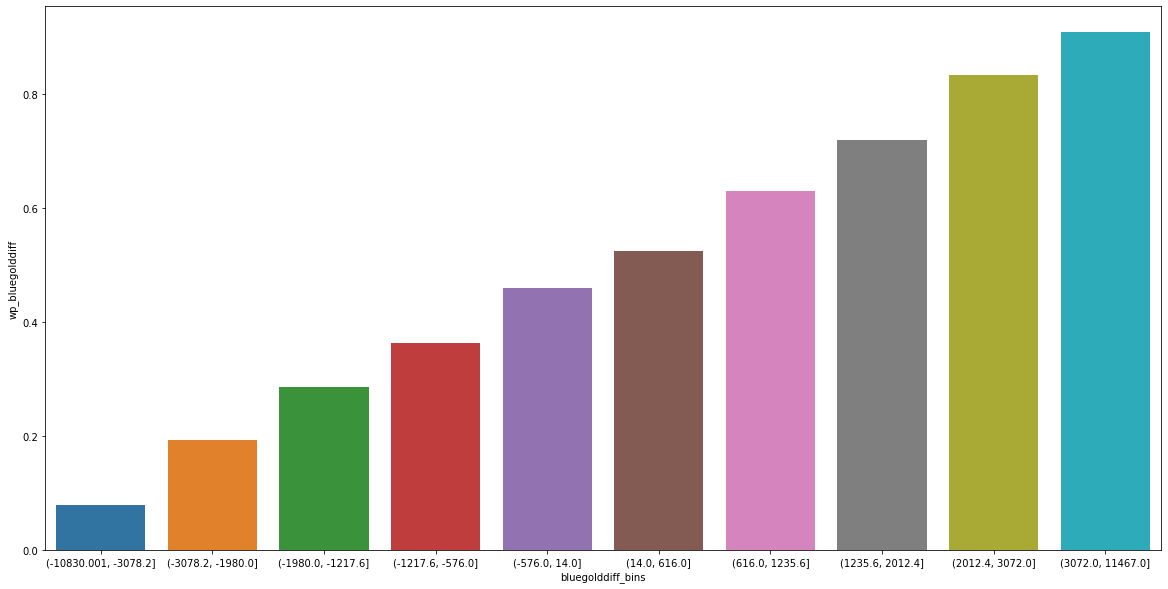

In [9]:
plt.figure(figsize=(20,10))
sns.barplot(x='bluegolddiff_bins', y='wp_bluegolddiff', data=pw_gd)
pw_gd

#### Blue experience Diff

The goal is pretty similar here starting in the fourth bin and trying to get to the 9th bin while avoiding the 0th bin. 


,blueexperiencediff_bins,wp_blueexperiencediff,Delta
0,"(-9333.001, -2456.2]",0.092105,0.130567
1,"(-2456.2, -1585.8]",0.222672,0.065789
2,"(-1585.8, -1019.6]",0.288462,0.085020
3,"(-1019.6, -523.8]",0.373482,0.081984
4,"(-523.8, -28.0]",0.455466,0.071275
5,"(-28.0, 427.0]",0.526741,0.093178
6,"(427.0, 943.6]",0.619919,0.091192
7,"(943.6, 1541.0]",0.711111,0.083007
8,"(1541.0, 2386.2]",0.794118,0.112765
9,"(2386.2, 8348.0]",0.906883,NaN


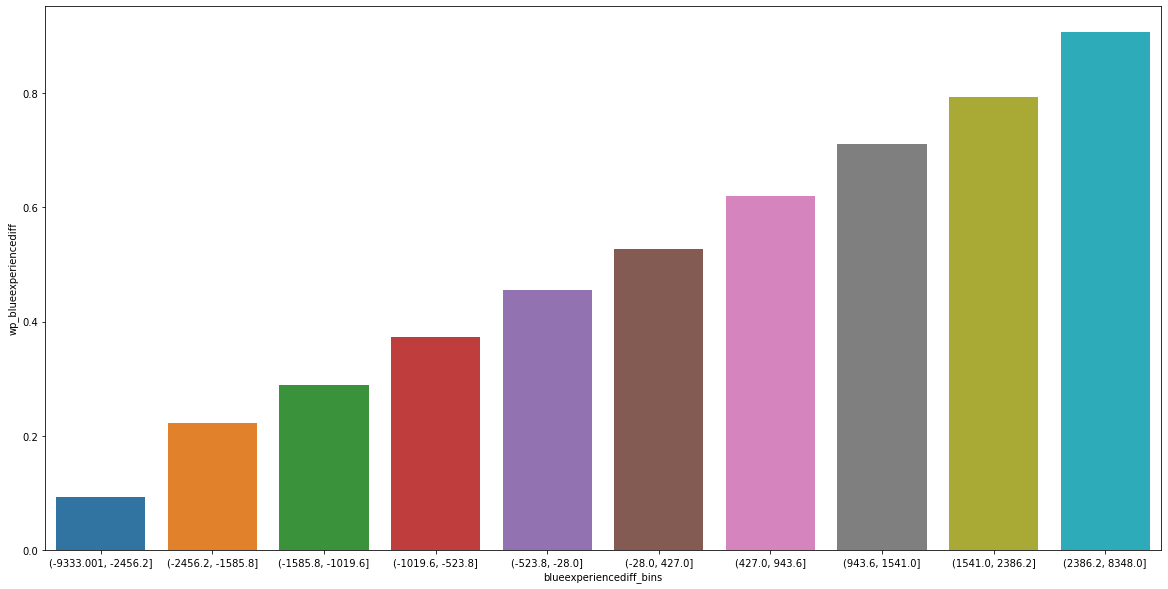

In [10]:
plt.figure(figsize=(20,10))
sns.barplot(x='blueexperiencediff_bins', y='wp_blueexperiencediff', data=pw_be)
pw_be

#### Blue gold per min

Regarding this bin, its best get out of that first bin, i.e accumulate more than 1601 gold per min or else the game becomes a lot harder.


,bluegoldpermin_bins,wp_bluegoldpermin,Delta
0,"(1072.999, 1464.58]",0.131579,0.146480
1,"(1464.58, 1519.5]",0.278059,0.065723
2,"(1519.5, 1563.2]",0.343782,0.035529
3,"(1563.2, 1601.08]",0.379310,0.084252
4,"(1601.08, 1639.8]",0.463563,0.088510
5,"(1639.8, 1679.6]",0.552073,0.039205
6,"(1679.6, 1720.56]",0.591278,0.075726
7,"(1720.56, 1773.74]",0.667004,0.064777
8,"(1773.74, 1849.62]",0.731781,0.120445
9,"(1849.62, 2370.1]",0.852227,NaN


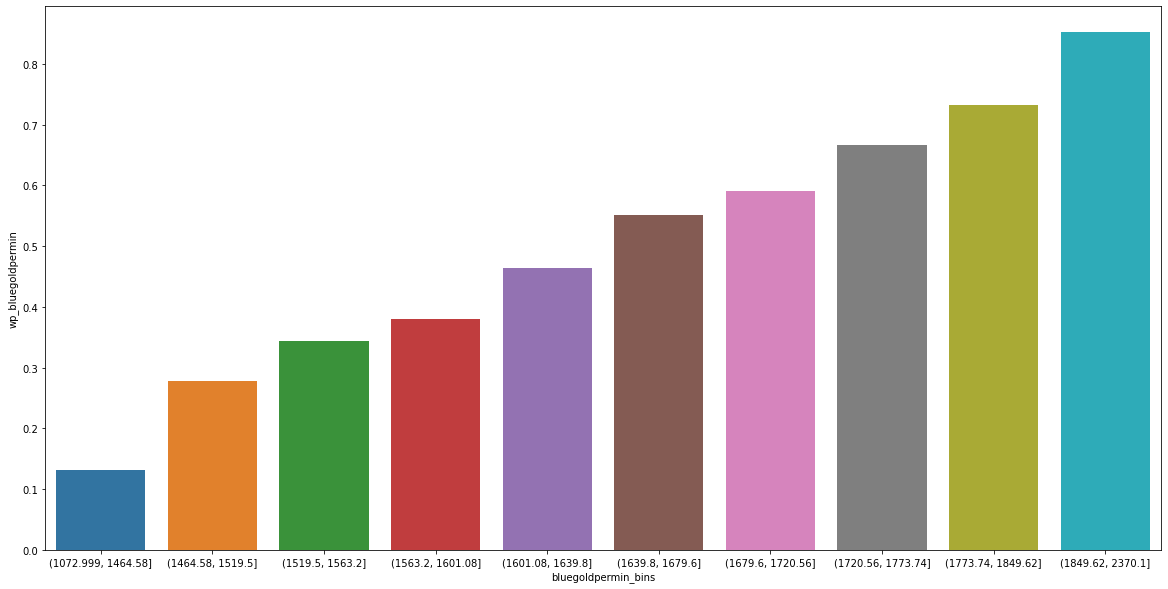

In [11]:
plt.figure(figsize=(20,10))
sns.barplot(x='bluegoldpermin_bins', y='wp_bluegoldpermin', data=pw_gm)
pw_gm

#### Blue total exp

This one is similar to the last. The 0th, 8th, 9th bins are key determinants to where your team might end up. 


,bluetotalexperience_bins,wp_bluetotalexperience,Delta
0,"(10097.999, 16392.8]",0.169028,0.103424
1,"(16392.8, 16956.0]",0.272452,0.081503
2,"(16956.0, 17345.0]",0.353955,0.046449
3,"(17345.0, 17668.0]",0.400404,0.083891
4,"(17668.0, 17951.0]",0.484296,0.044044
5,"(17951.0, 18250.0]",0.528340,0.035866
6,"(18250.0, 18561.0]",0.564206,0.070682
7,"(18561.0, 18922.0]",0.634888,0.101687
8,"(18922.0, 19429.4]",0.736575,0.110591
9,"(19429.4, 22224.0]",0.847166,NaN


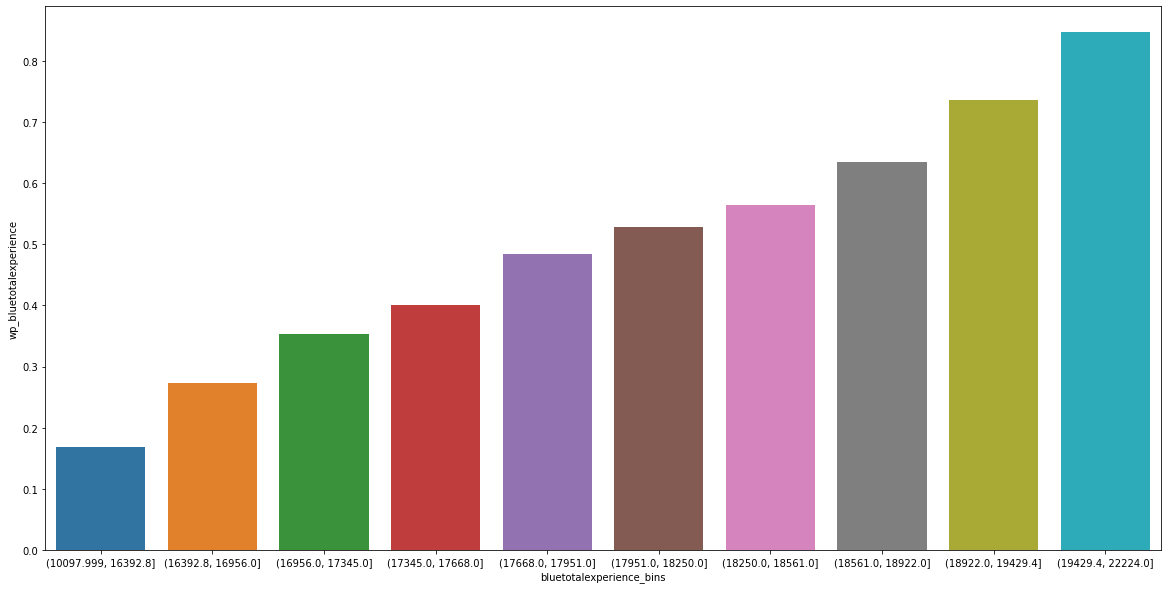

In [12]:
plt.figure(figsize=(20,10))
sns.barplot(x='bluetotalexperience_bins', y='wp_bluetotalexperience', data=pw_te)
pw_te

#### Blue team total minions

This one is interesting in that even the 0th bin still leaves the team with a 20% chance of winning the match on average. So it might be a good idea to pick team battles for lanes in a way that minimizes minions lost and places the team effort into something more fruitful


,bteamtotminionsdiff_bins,wp_bteamtotminionsdiff,Delta
0,"(-173.001, -46.0]",0.222004,0.065458
1,"(-46.0, -31.0]",0.287462,0.081800
2,"(-31.0, -20.0]",0.369261,0.053204
3,"(-20.0, -10.0]",0.422465,0.052180
4,"(-10.0, -1.0]",0.474645,0.047729
5,"(-1.0, 8.0]",0.522374,0.073418
6,"(8.0, 16.0]",0.595792,0.007830
7,"(16.0, 27.0]",0.603622,0.096179
8,"(27.0, 43.0]",0.699801,0.116953
9,"(43.0, 154.0]",0.816754,NaN


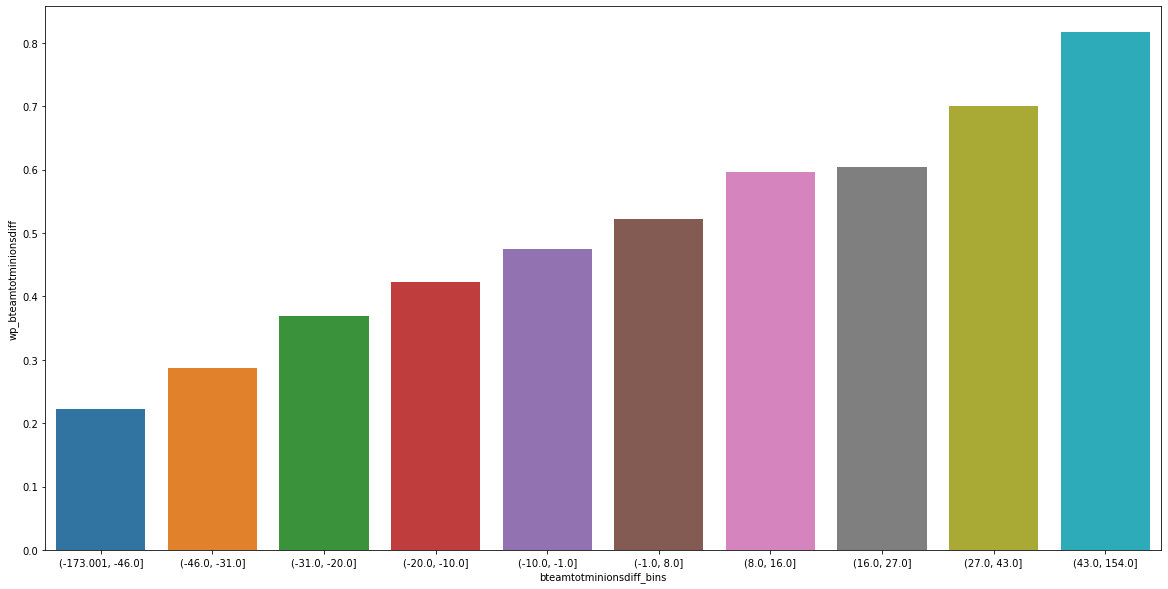

In [13]:
plt.figure(figsize=(20,10))
sns.barplot(x='bteamtotminionsdiff_bins', y='wp_bteamtotminionsdiff', data=pw_tm)
pw_tm

#### Blue lane minion difference

Somewhat of the same deal here


,blaneminions_diff_bins,wp_blaneminions_diff,Delta
0,"(-120.001, -40.0]",0.256207,0.044286
1,"(-40.0, -26.0]",0.300493,0.105222
2,"(-26.0, -16.0]",0.405714,0.048362
3,"(-16.0, -8.0]",0.454076,0.005151
4,"(-8.0, -1.0]",0.459227,0.060503
5,"(-1.0, 7.0]",0.519731,0.041580
6,"(7.0, 15.0]",0.561311,0.049066
7,"(15.0, 25.0]",0.610376,0.058361
8,"(25.0, 38.0]",0.668737,0.109041
9,"(38.0, 127.0]",0.777778,NaN


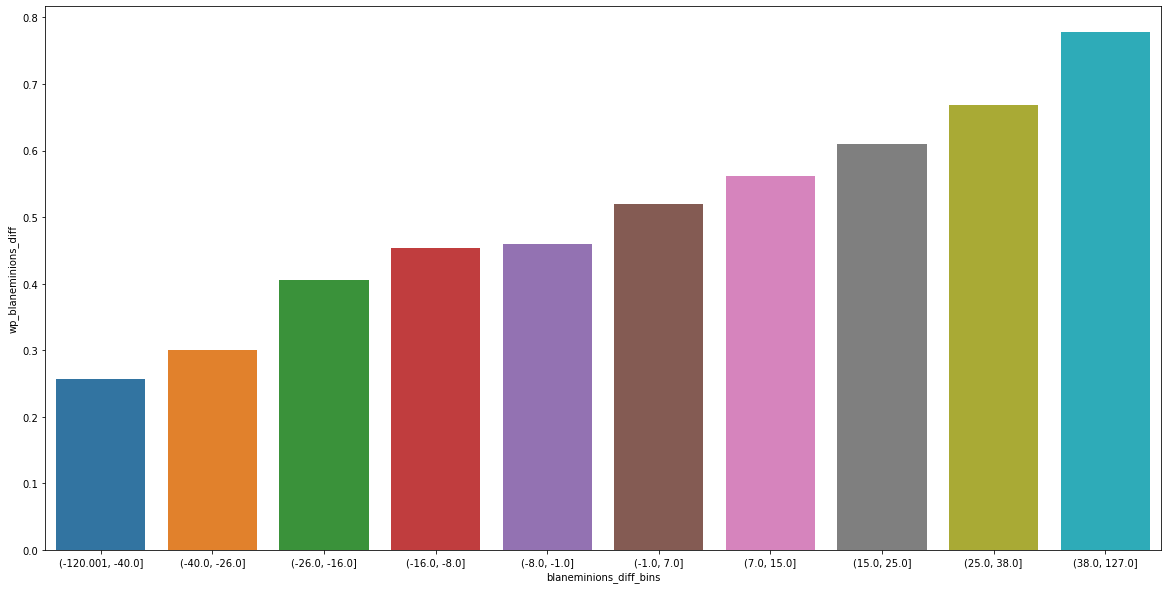

In [14]:
plt.figure(figsize=(20,10))
sns.barplot(x='blaneminions_diff_bins', y='wp_blaneminions_diff', data=pw_lm)
pw_lm

#### Blue total gold

The difference between bins 0 and 1 are the biggest we observed so far. Just being in bin 1 give you an average 27-28 percent chance. 12 point bonus on reaching that last bin too. A feature that I would definitely watch all game, something that is always on display during Pro-level games.


,bluetotalgold_bins,wp_bluetotalgold,Delta
0,"(10729.999, 14645.8]",0.131579,0.146480
1,"(14645.8, 15195.0]",0.278059,0.065723
2,"(15195.0, 15632.0]",0.343782,0.035529
3,"(15632.0, 16010.8]",0.379310,0.084252
4,"(16010.8, 16398.0]",0.463563,0.088510
5,"(16398.0, 16796.0]",0.552073,0.039205
6,"(16796.0, 17205.6]",0.591278,0.075726
7,"(17205.6, 17737.4]",0.667004,0.064777
8,"(17737.4, 18496.2]",0.731781,0.120445
9,"(18496.2, 23701.0]",0.852227,NaN


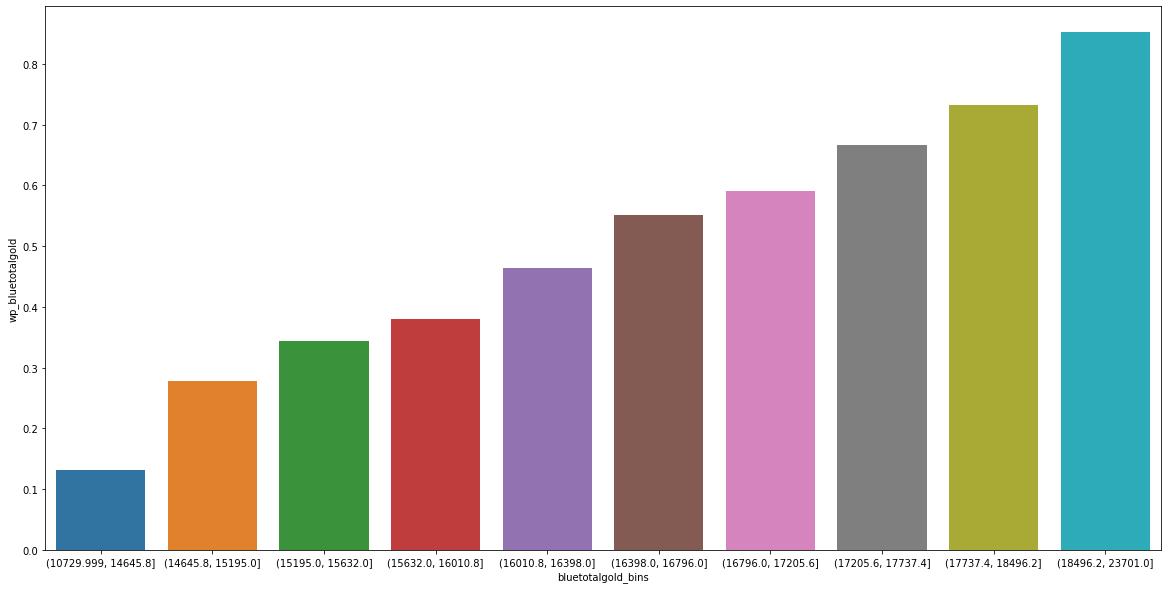

In [15]:
plt.figure(figsize=(20,10))
sns.barplot(x='bluetotalgold_bins', y='wp_bluetotalgold', data=pw_tg)
pw_tg

### Modeling 

#### How Does the 2 Hidden Layer MLP work?

What I built was a DeepNet with 2 hidden layers. There are 7 variables that are feed into a node on their own which allows us to start feeding forward information. These 7 nodes feed the next layer of 70 nodes this input. The DeepNet needs to start with some weights and then iteratively update them to reduce loss. The kernel initializer provides a function to use for initializing the weights applied to the information received from the previous node, before applying the activation function. After that is done the same process is repeated in the second layer with different hyperparameters trained in a different notebook.|

In [16]:
X = df.iloc[:, 2:]
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X_df = pd.DataFrame(X_stand, columns=X.columns)
y = df.iloc[:, 1:2].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [17]:
%%time
def build_mlp():
  model = keras.Sequential([keras.layers.Dense(70, input_shape=(None, 7), kernel_initializer='glorot_normal',
                                               activation='sigmoid',),
                            keras.layers.Dense(70, activation='selu', kernel_initializer='normal'),
                            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')])
  optomizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.1)
  model.compile(optimizer=optomizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
  
seed = 7
np.random.seed(seed)
mlp_model = build_mlp()
mlp_model.fit(X_train, y_train, batch_size=15, epochs=100, verbose=1)

y_mlp2 = mlp_model.predict(X_test).ravel()

Epoch 1/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5761 - accuracy: 0.7009
Epoch 2/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5655 - accuracy: 0.7137
Epoch 3/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5672 - accuracy: 0.7182
Epoch 4/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5593 - accuracy: 0.7192
Epoch 5/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5603 - accuracy: 0.7161
Epoch 6/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5613 - accuracy: 0.7202
Epoch 7/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5574 - accuracy: 0.7150
Epoch 8/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5576 - accuracy: 0.7190
Epoch 9/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5591 - accuracy: 0.7193
Epoch 10/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5613 - accura

#### Hyperparameter Tuning

Here’s cell construction that leads to the model provided in this report. Most of the parameters specified were chosen by a cell like this. Doing multiple tests across each parameter to find the best one for each layer manually. Some parameters were chosen with other parameters during Grid Searching in a way that made sense to me. The order in which parameters were tested was as follows: optimization algorithm, learning rate, and momentum, kernel initializer, Activation Function, Dropout rate and AlphaDropout for the second level because of the synergy created with the ‘selu’ activation function used, batch size and epochs, finally neurons per layer, excluding the last layer.

After doing that for a while, I got an idea to compose a cell that could help me uncover possible blind spots to the previous way of training by essentially testing more scenarios at once.

In [ ]:
## Grid to determine each layer's activation function
def create_model(activation='softmax'):
  model = keras.Sequential([keras.layers.Dense(70, input_shape=(None, 7), activation='sigmoid'),
                            keras.layers.Dense(70, activation='selu'),
                            keras.layers.Dense(1, activation=activation)])
  opt = tf.keras.optimizers.Adagrad(learning_rate=0.005, initial_accumulator_value=0.1, epsilon=1e-07)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# defining grid search parameters
activation = ["tanh", "sigmoid", 'relu', 'selu', 'softsign', 'softmax']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

#### Hyperparameter Tuning continued…

Here’s overall where I landed. This didn’t work as well as I thought. I had a hard time quantifying the computational limits of my environment and keeping the model parameter options within that limit. To be honest, there’s probably a better way to compose this algorithm. Perhaps in a fashion that would provide more consistent results (referring to printing a result before the kernel died) and/or quantifying my problem in a solvable manner given the time constraints.

The last layer receives the output from the second hidden layer and returns an output (for each game the model is used on this output is a number between 0 and 1) that I used for predictions. Should also note that there was no class imbalance, to begin with. 


In [ ]:
# STAR GRID CELL
def create_model(learning_rate=0.001, momentum=0.0, optimizer='SGD',
                 loss='binary_crossentropy', init_mode='uniform', neurons=1,
                 activation='sigmoid', dropout_rate=0.0, weight_constraint=0):
  model = keras.Sequential([keras.layers.Dense(neurons, input_shape=(None, 7), kernel_initializer='glorot_normal', activation=activation, kernel_constraint=maxnorm(weight_constraint),),
                            keras.layers.Dropout(dropout_rate),
                            keras.layers.Dense(neurons, activation=activation, kernel_initializer='normal'),
                            keras.layers.Dropout(dropout_rate),
                            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')])
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
weight_constraint = [0, 2, 4, 6]
dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]
activation = ["tanh", "sigmoid", 'relu', 'softmax'] 
init_mode = ['uniform', 'normal', 'glorot_normal', 'he_normal', 'he_uniform'] 
loss = ['binary_crossentropy']
neurons = [70, 85, 100]
learning_rate = [0.001, 0.01, 0.05, 0.1]
momentum = [.0, .2, .4]
batch_size = [14, 34, 72]
epochs = [200]

# Create Parameter Grid Object & Train Model
param_grid = dict(learning_rate=learning_rate, momentum=momentum,
                  batch_size=batch_size, epochs=epochs,
                  loss=loss, optimizer=optimizer,
                  activation=activation,
                  weight_constraint=weight_constraint,
                  dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#### 7 Hidden layer MLP
This model was trained in a similar fashion to the previous just with more layers.

In [22]:
%%time
def build_mlp():
  model = keras.Sequential([keras.layers.Dense(1300, input_shape=(None, 7), kernel_constraint=maxnorm(2),
                                               kernel_initializer='glorot_normal'),
                            keras.layers.Dropout(0.4),
                            keras.layers.Dense(1300, kernel_initializer='uniform', activation='linear'),
                            keras.layers.Dense(1600, kernel_initializer='glorot_normal', activation='linear'),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(1000, kernel_initializer='uniform', activation='linear'),
                            keras.layers.Dropout(0.6),
                            keras.layers.Dense(1400, kernel_initializer='glorot_normal', activation='linear'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(2000, kernel_initializer='he_normal', activation='linear'),
                            keras.layers.Dropout(0.8),
                            keras.layers.Dense(1000, kernel_initializer='normal', activation='linear'),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(1, activation='sigmoid')])
  optomizer = tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.8)
  model.compile(optimizer=optomizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
  
seed = 7
np.random.seed(seed)
mlp_model = build_mlp()
mlp_model.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1)

y_mlp7 = mlp_model.predict(X_test).ravel()

Epoch 1/10
80/80 [==============================] - 18s 226ms/step - loss: 21037658201391104.0000 - accuracy: 0.5994
Epoch 2/10
80/80 [==============================] - 17s 219ms/step - loss: 5792510186094592.0000 - accuracy: 0.5999
Epoch 3/10
80/80 [==============================] - 18s 219ms/step - loss: 2974204454502400.0000 - accuracy: 0.5819
Epoch 4/10
80/80 [==============================] - 17s 218ms/step - loss: 522438379044864.0000 - accuracy: 0.6026
Epoch 5/10
80/80 [==============================] - 17s 218ms/step - loss: 23325735456342016.0000 - accuracy: 0.5717
Epoch 6/10
80/80 [==============================] - 17s 218ms/step - loss: 33510425765085184.0000 - accuracy: 0.5714
Epoch 7/10
80/80 [==============================] - 17s 217ms/step - loss: 9554589615390720.0000 - accuracy: 0.5940
Epoch 8/10
80/80 [==============================] - 17s 216ms/step - loss: 1300280142462976.0000 - accuracy: 0.5919
Epoch 9/10
80/80 [==============================] - 18s 220ms/step - l

### Model Evaluation & Selection

Here I will be comparing these model scores discussing the pros and cons to each. Since we have information about the outcome of these games, I can use evaluation algorithms that consider the ground truth of interest. 

The evaluation metrics I will use here are Fowlkes-Mallows index and the adjusted rand score. 

The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall. Random label assignments have a score close to 0.0 and the score has a upper bound at 1. So we can evaluate the randomness of label assignments and have a "perfect" upward bound to aim for. 

Unsupervised methods typically should not be evaluated using only one metric and thats where ARI score comes in. The ARI has a bounded range of [-1, 1], with negative scores equating to 'bad' label assignments, positive scores are what we are looking for, and scores close to 0 equate to random label assignments. 



In [28]:
print('Scores for the 3 Hidden Layer MLP')
print('Fowlkes Mallows Score : ', metrics.fowlkes_mallows_score(y_test,  y_mlp2.round(decimals=0, out=None)))
print('Adjusted Rand Score : ', metrics.adjusted_rand_score(y_test, y_mlp2.round(decimals=0, out=None)))
print()
print('Scores for the 7 Hidden Layer MLP')
print('Fowlkes Mallows Score : ', metrics.fowlkes_mallows_score(y_test,  y_mlp7.round(decimals=0, out=None)))
print('Adjusted Rand Score : ', metrics.adjusted_rand_score(y_test, y_mlp7.round(decimals=0, out=None)))

Scores for the 3 Hidden Layer MLP
Fowlkes Mallows Score :  0.6130779183925622
Adjusted Rand Score :  0.2230210436876686

Scores for the 7 Hidden Layer MLP
Fowlkes Mallows Score :  0.7073973480625426
Adjusted Rand Score :  0.0


Based on the above scores, I'd select the 2 layer MLP over the 7 layer MLP. The loss observed was absurd and the ARI being 0.0 means that output seemed perfectly random.  Even though a higher FMI score was observed, it is not a reliable model.

### Limitations and Future Work

Think back to hyperparameter tuning of the MLP - the output of the final node is actually a value between or including 0 and 1. Here’s the distribution of that output. As we can see, there is some middle ground here that could be exposed to develop some cool near win/loss analysis. But also as an additional usability case, you can use this to determine where your game is by running the model after you pull the data into a notebook and architected a structure to get here.

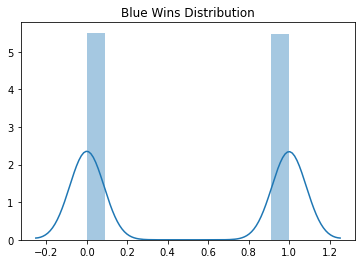

In [25]:
plt.title('Blue Wins Distribution')
sns.distplot(y)

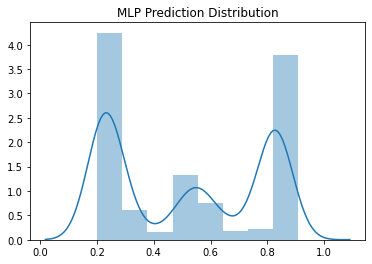

In [27]:
plt.title("MLP Prediction Distribution")
sns.distplot(y_mlp2)

#### Limitations and Future Work continued

Player Positivity Score
  * Communication is key in this game
  * Swearing is reported by RIOT to negatively affect win rate
  * And I can personally confirm that your teammates may tilt you if you go in
  without tough skin and reminding players it's just a game may not help LOL

More Data AKA More Games
Ten-minute snapshot
  * Could use whole games
  * Could also use the time dimension

Could Answer more pinpointed questions - (Surrender becomes available at 14 minutes) How many teams ff when they have more than a 40% chance of winning?


Also, there are various minion types from 2 different lane minions to different jungle and rift minions that provide different team buffs, and the return on those haven't been investigated here.

Player skill information relating to the role
  * If you “main” mid then forced to the jungle you may perform under the
  the expected curve of player performance which creates openings for the enemy
  team to take advantage of

Player skill relating to champion
  * Most players look at their “main” champs win rate 
  * What about the champ they are playing against
  * Could be a counter pick (picked during champion select that has a natural 
  the advantage over another champion)

Late or Early Game Team orientation
  * Score composed based on the champions on a team and when their power spikes 
  dropoff is likely to occur
  * “Early Game Teams” have more power in the early game but tend to fall off 
  later
  * There is also the concept of “Late Game Teams”

Season Patch
  * Champion and item buffs and nerfs certainly may have an effect

### Example Use Cases

- You could predict on your own game

- A team with a coach could use this model for premium game information

- Pregame information to determine where your energy as a player is best spent. Also sharing the information with your team

- To save time, if you're just getting wrecked in a department that leaves your team in a definite loss zone you could use this to know if you should FF. Games can last around 1 to 2 hours but can be resolved in a lot less. Saving everyone a little time and frustration


Thanks for checking out the notebook!

Best, 

Lateef